<a href="https://colab.research.google.com/github/Harrisous/AI-Tutorials/blob/main/GradCAM_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI Tutorial - Explainable DL - GradCAM
## by Haochen Li
In this totorial, we will learn how to use GradCAM to explain a CV model (ResNet50) on cat and dog classification task. The breakdown steps are as follows:  
1. Load Cat Dog Dataset to Colab;
2. Apply transfer Learning/finetuning to the pre-trained ResNet50 to recognize cat;
3. Save model for future use (optional);
3. Use Grad-CAM to explain the prediction result.

Let's go!

Below are the hyperparameters for transfer learning. Modify if the training resource is not fully utilized or is limited. T4 untime should be able to run with the following setting perfectly.

In [1]:
# manual set the key parameters for transfer learning
transfer_epoch = 20 # transfer learning epoch, 3 for test run, 20 for official run
batch_size = 110 # batch size for training
num_workers = 16 # number of workers(CPU) for dataloader

# Step 1: Load Cat Dataset to Colab
We will be using Kaggle dataset: https://www.kaggle.com/datasets/alvarole/asirra-cats-vs-dogs-object-detection-dataset

To download to our colab files, you need to get Kaggle API key. Here his how you can get it: Kaggle → Account → API → Create New API Token. Then it will be downloaded to your local drive with the name of "kaggle.json"

The next block is where you upload Kaggle API token for future download

In [2]:
# upload personal Kaggle API token (kaggle.json) to Colab
import os
if not os.path.exists('asirra-cats-vs-dogs-object-detection-dataset.zip'):
  from google.colab import files
  files.upload()  # Select kaggle.json from your local machine

  # move kaggle.json to the correct location
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
else:
  print('kaggle.json already exists, skipping upload.')

kaggle.json already exists, skipping upload.


In [3]:
# install Kaggle API and required packages
!pip install -q kaggle torch torchvision matplotlib

In [4]:
# download Cat Dog dataset from Kaggle
import os
# check if the zip file already exists
if not os.path.exists('asirra-cats-vs-dogs-object-detection-dataset.zip'):
    # If not, download and unzip
    !kaggle datasets download -d alvarole/asirra-cats-vs-dogs-object-detection-dataset
    !unzip asirra-cats-vs-dogs-object-detection-dataset.zip -d asirra_dataset
else:
    print('zip file already exists, skipping download and unzip.')

zip file already exists, skipping download and unzip.


In [5]:
# check extracted folders
import os
print(os.listdir('asirra_dataset/Asirra: cat vs dogs'))

['cat.3636.jpg', 'cat.3702.xml', 'cat.3586.xml', 'dog.4.jpg', 'dog.174.jpg', 'cat.3781.jpg', 'dog.499.jpg', 'cat.3752.xml', 'cat.3509.jpg', 'cat.3540.jpg', 'dog.249.xml', 'cat.8.xml', 'dog.338.jpg', 'cat.3842.xml', 'cat.3909.xml', 'dog.91.xml', 'dog.57.xml', 'dog.87.jpg', 'cat.3665.xml', 'dog.126.jpg', 'dog.3515.jpg', 'cat.27.xml', 'cat.3738.xml', 'cat.3700.xml', 'cat.3647.xml', 'dog.152.jpg', 'dog.3528.xml', 'cat.3570.jpg', 'cat.3955.jpg', 'dog.181.jpg', 'dog.202.jpg', 'cat.3811.xml', 'cat.0.jpg', 'dog.190.jpg', 'dog.15.xml', 'cat.3644.jpg', 'cat.3874.jpg', 'cat.3843.jpg', 'dog.46.xml', 'dog.149.xml', 'cat.1.jpg', 'dog.396.jpg', 'dog.184.jpg', 'cat.3682.xml', 'cat.3768.jpg', 'dog.10.jpg', 'cat.3809.jpg', 'dog.124.jpg', 'dog.148.jpg', 'cat.3925.xml', 'cat.3719.jpg', 'cat.3946.xml', 'dog.3549.jpg', 'cat.3543.xml', 'cat.48.jpg', 'cat.3893.xml', 'dog.2.jpg', 'dog.273.xml', 'dog.328.jpg', 'dog.106.jpg', 'dog.140.jpg', 'dog.123.xml', 'cat.3645.jpg', 'dog.31.xml', 'cat.3948.jpg', 'cat.3777.j

Now let's check what are the images inside the extracted folder.

In [6]:
import os
img_dir = f'asirra_dataset/Asirra: cat vs dogs'
img_list_cat = [f for f in os.listdir(img_dir) if f.endswith('.jpg') and f.startswith('cat')]
img_list_dog = [f for f in os.listdir(img_dir) if f.endswith('.jpg') and f.startswith('dog')]
print('total number of cat pictures:', len(img_list_cat))
print('total number of dog pictures:', len(img_list_dog))

total number of cat pictures: 550
total number of dog pictures: 550


# Step 2 Transfer Learning

In this step, we will apply transfer learning to the pretrained ResNet 50. But before that, we need to check if CUDA is available. Run the below code to and check if the output is "CUDA available: True". If yes, that means GPU is detected in your current runtime; if not, please consider change runtime to includ a GPU and re-run the notebook.

In [7]:
# Check if GPU is available
import torch
print('CUDA available:', torch.cuda.is_available())

CUDA available: True


Next, we need to build a custom dataset for dataloader.

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = 1 if 'dog' in self.image_files[idx] else 0  # dog = 1, cat = 0

        if self.transform:
            image = self.transform(image)
        return image, label


Next block is the transformer that will do the inital transformation to raw pictures to faciliate and standardize the training process.

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

Next, we create the customized dataset object with transformer and split it into train and validation set. Train set is for transfer learning and validation set is for validate the performance and check if the model is underfitted or overfitted.  
Then the data will be put into data loaders (train_loader and val_loader) for official training run.

In [10]:
dataset = CatDogDataset(root_dir=img_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
# check the train vs val split
print('number of batches per epoch for training samples', len(train_loader))
print('number of batches per epoch for validation samples', len(val_loader))

number of batches per epoch for training samples 8
number of batches per epoch for validation samples 2


Next, we finetune the pre-trained ResNet50 using the dataloaders we created before.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pre-trained ResNet50
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: cat or dog
model = model.to(device)

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# define training configuration
best_val_loss = float('inf')

# training + validation Loop
for epoch in range(transfer_epoch):
    # training starts
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # validation starts
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # epoch summary
    print(f"Epoch [{epoch+1}/{transfer_epoch}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # save model for future use, you can download it to local drive
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resnet50_asirra.pth")
        print(f"Validation loss improved, model saved.")

print("Training complete.")



Epoch [1/20] Train Loss: 0.2557 | Train Acc: 91.82% | Val Loss: 0.1486 | Val Acc: 96.82%
Validation loss improved, model saved.
Epoch [2/20] Train Loss: 0.0481 | Train Acc: 97.95% | Val Loss: 0.2971 | Val Acc: 93.64%
Epoch [3/20] Train Loss: 0.0247 | Train Acc: 99.20% | Val Loss: 0.0525 | Val Acc: 97.73%
Validation loss improved, model saved.
Epoch [4/20] Train Loss: 0.0071 | Train Acc: 99.89% | Val Loss: 0.1098 | Val Acc: 95.00%
Epoch [5/20] Train Loss: 0.0021 | Train Acc: 100.00% | Val Loss: 0.0665 | Val Acc: 96.36%
Epoch [6/20] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.0468 | Val Acc: 97.27%
Validation loss improved, model saved.
Epoch [7/20] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.0681 | Val Acc: 95.45%
Epoch [8/20] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.0605 | Val Acc: 96.36%
Epoch [9/20] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.0496 | Val Acc: 97.73%
Epoch [10/20] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.0519 | Va

# Step 3 (Optional) Save Model File
Find the file best_resnet50_asirra.pth and click the three dots -> download. Then it will be downloaded to local drive and you can load it in other projects.

# Step 4 Grad-CAM explanation
Finally, we are going to use Grad-CAM to explain the model prediction and check if it is aligned with human logic/knowledge. Note we will load the saved model. That is because the last model snapshot may not be the best model due to overfitting. The best model is based on lowest val loss, which indicate the model robustness to unseen data.


In [13]:
# install grad-cam lib
!pip install -q grad-cam

In [14]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load from saved best model pth
model = resnet50(weights=None)  # initialize empty and load later
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("best_resnet50_asirra.pth", map_location=device))
model.eval().to(device)
print("model loaded")

model loaded


Next, we randomly pick 5 cats and 5 dogs pictures from the dataset and apply Grad-CAM

In [15]:
import os
import glob

dataset_path = img_dir
cat_images = random.sample(glob.glob(os.path.join(dataset_path, "cat.*.jpg")), 5)
dog_images = random.sample(glob.glob(os.path.join(dataset_path, "dog.*.jpg")), 5)
selected_images = cat_images + dog_images


In [16]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layer = model.layer4[-1]  # last convolutional block
cam = GradCAM(model=model, target_layers=[target_layer])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def apply_gradcam(img_path):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    rgb_img = np.array(img_resized) / 255.0

    input_tensor = transform(img_resized).unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization

results = [(img, apply_gradcam(img)) for img in selected_images]


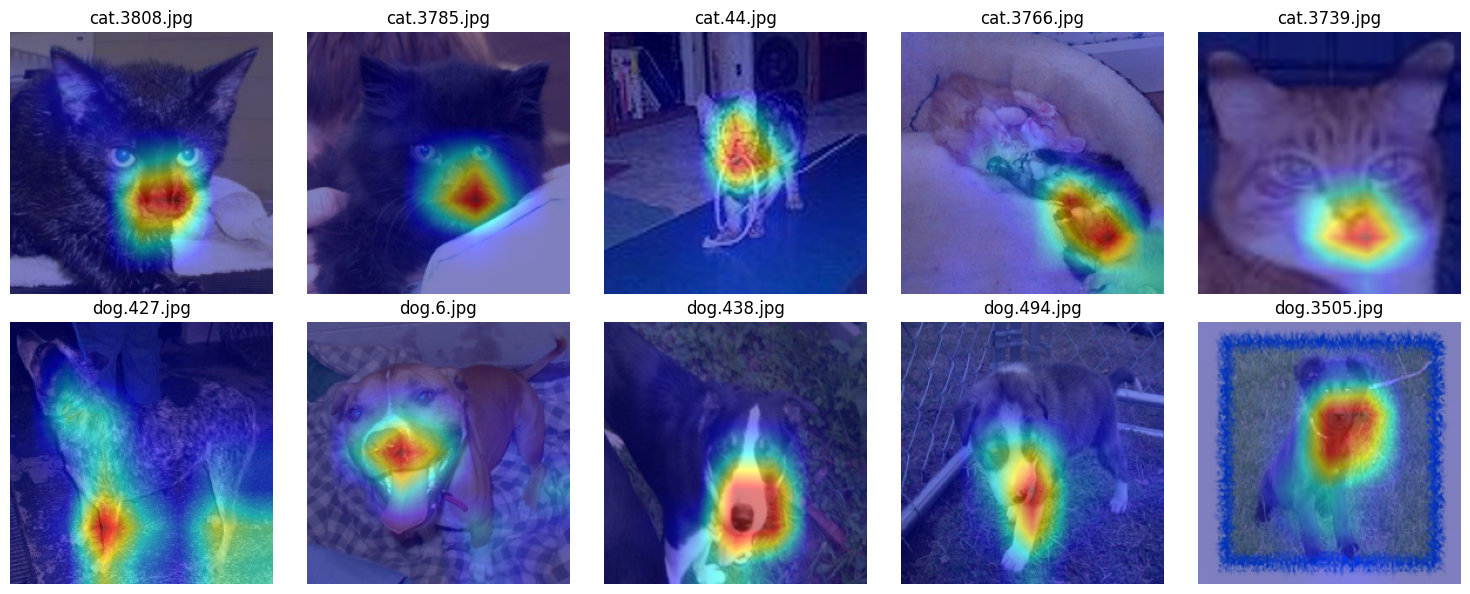

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (img_path, visualization) in enumerate(results):
    axes[i//5, i%5].imshow(visualization)
    axes[i//5, i%5].set_title(os.path.basename(img_path))
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

As you can see, the model mainly focus on the nose and mouth to distinguish cats and dogs.

In order to make the model learn more things, you can fine-tune it with other datasets and see why it makes such prediction.

Next is the the part where you can upload your own picture and get the prediction & Grad-CAM visulization.

Saving banana_cat.png to banana_cat.png


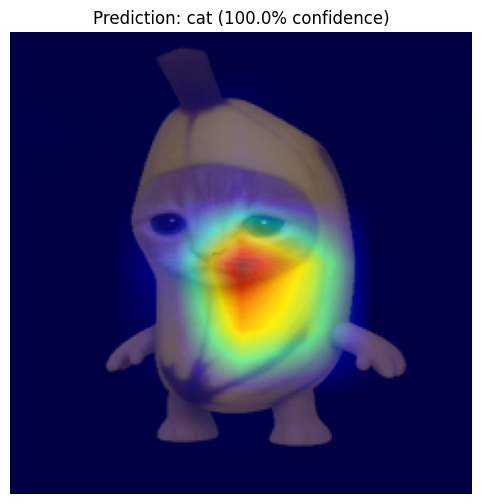

In [18]:
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

uploaded = files.upload()

for file_name in uploaded.keys():
    img_path = file_name

img = Image.open(img_path).convert('RGB')
img_resized = img.resize((224, 224))
rgb_img = np.array(img_resized) / 255.0

# make prediction on the uploaded picture
input_tensor = transform(img_resized).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

label_map = {0: 'cat', 1: 'dog'}
pred_label = label_map[pred_class]
confidence = probs[pred_class].item()

# Grad-CAM
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor)[0, :]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# display result visualization
plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.axis('off')
plt.title(f"Prediction: {pred_label} ({confidence*100:.1f}% confidence)")
plt.show()
